# Almgren-Chriss Optimal Execution Model
*Joshua Paul Jacob*

The aim of the Almgren-Chriss optimal execution model is to minimize a combination of volatility risk and transaction costs arising from permanent and temporary market impact. In this notebook, we study the model for liquidation of large positions with real financial data.

Based on Almgren, R. and Chriss, N., 2001. Optimal execution of portfolio transactions. The Journal of Risk, 3(2), pp.5-39.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm

## Single Asset

We first numerically illustrate the Almgren-Chriss model with financial data for one asset. In particular, we study optimal daily liquidation trajectory with the daily historical prices of Alphabet Inc. (NASDAQ:GOOG) during the past three months.

### Data
We use the Yahoo Finance API to obtain historical price data.

In [2]:
goog = yf.Ticker('GOOG')
data = goog.history(period='3mo')
display(data)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-13,2767.149902,2773.479980,2760.100098,2768.120117,628600,0,0
2021-08-16,2760.000000,2779.810059,2723.314941,2778.320068,902000,0,0
2021-08-17,2763.820068,2774.370117,2735.750000,2746.010010,1063600,0,0
2021-08-18,2742.310059,2765.879883,2728.419922,2731.399902,746700,0,0
2021-08-19,2709.350098,2749.040039,2707.120117,2738.270020,914800,0,0
...,...,...,...,...,...,...,...
2021-11-08,3000.000000,3020.689941,2982.399902,2987.030029,919400,0,0
2021-11-09,2994.919922,3007.570068,2950.139893,2984.969971,843800,0,0
2021-11-10,2960.195068,2974.000000,2906.500000,2932.520020,1135400,0,0


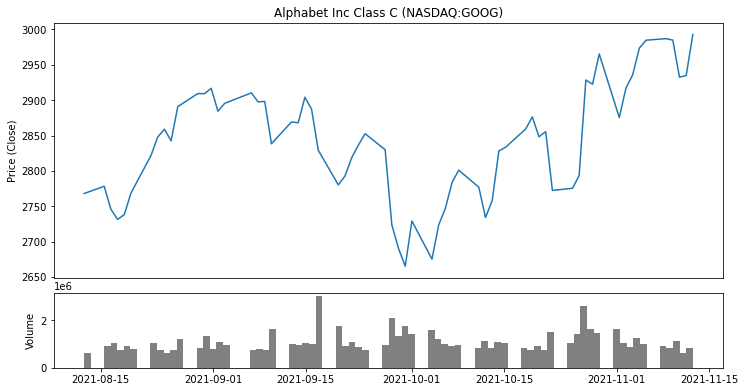

In [3]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(data.index, data["Close"])
top_plt.set_ylabel('Price (Close)')
top_plt.set_xticks([])
plt.title('Alphabet Inc Class C (NASDAQ:GOOG)')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(data.index, data['Volume'], width=1, color="grey")
bottom_plt.set_ylabel('Volume')
plt.gcf().set_size_inches(12,8)

### Parameter Calibration

We explain the meaning of the different parameters and compute the parameters with the data. Let $X$ be the initial position. We wish to liquidate, setting our position to 0. Let $T$ be the time we have to liquidate.

- $\lambda$ is a risk-aversion parameter. The smaller $\lambda$ is, the more risk the agent is willing to take.
- $\sigma$ is a measure of the volatility of the asset. It is the standard deviation of the daily price. For the sake of this example, we compute $\sigma$ using the data of future prices for a trading strategy in the past. This would not be possible in real implementations where $\sigma$ would have to be estimated.
- $\epsilon$ is a temporary market impact parameter. It is calibrated as half of the average bid/ask spread plus fees. Again, in real implementations, we cannot know the future spread, hence $\epsilon$ would have to be estimated. 
- $\eta$ is another temporary market impact parameter. It depends on internal and transient aspects of the market microstructure. This makes it hard to approximate. It is in this term that we would expect non-linear effects to be most important.
- $\gamma$ is a permanent market impact parameter. Assuming linear market impact, each $n$ units that the agent sells, depresses the price per unit by $\gamma n$.
- $\tau = \frac{T}{N}$ is the size of the period in which we can make an order i.e. the agent can trade at each time $t_k = k\tau$ for $k=0,...,N$. In this example, we take $\tau$ to be one day which means we can make an order each day. 

We use the daily closing price as the daily price of the asset.

We calibrate $\eta$ and $\gamma$ as 

$$\eta = \frac{\text{Spread}}{0.01 \times \text{Avg. Daily Volume}}$$

$$\gamma = \frac{\text{Spread}}{0.1 \times \text{Avg. Daily Volume}}$$


In [4]:
average_daily_volume = np.mean(data['Volume'])
average_daily_spread = np.mean(data['High'] - data['Low'])

sigma = np.std(data['Close'])
epsilon = average_daily_spread/2
eta = average_daily_spread/(0.01*average_daily_volume)
gamma = average_daily_spread/(0.1*average_daily_volume)
tau = 1

params = {
    'lambda': 1e-08,
    'sigma': sigma,
    'epsilon': epsilon,
    'eta': eta,
    'gamma': gamma,
    'tau': tau
}

print('Parameters:')
for k,v in params.items():
    print('  {} = {}'.format(k,v))

Parameters:
  lambda = 1e-08
  sigma = 81.51807779004089
  epsilon = 24.146854341947115
  eta = 0.004364364605672711
  gamma = 0.000436436460567271
  tau = 1


### Implementation

A trading trajectory is a vector $(x_0,..,x_N)$ where $x_k$ is the number of units of the asset that the agent plans to hold at time $t_k$. Given $\lambda$, $\sigma$, $\epsilon$, $\eta$, $\gamma$, and $\tau$, we can compute the optimal trading trajectory $(x_0,..,x_N)$ for initial position $X$ and time-to-liquidate $T$ with the following equations:

$$\tilde{\eta} = \eta - \frac{\gamma \tau}{2}$$

$$\tilde{\kappa}^2 = \frac{\lambda \sigma^2}{\tilde{\eta}}$$

$$\frac{2}{\tau^2}\left(\cosh(\kappa \tau) - 1\right) = \tilde{\kappa}^2 \iff \kappa = \frac{1}{\tau}\text{arccosh}\left(\frac{\tilde{\kappa}^2 \tau^2}{2} + 1\right)$$

$$x_k = \frac{\sinh(\kappa(T-t_k))}{\sinh(\kappa T)}X, \quad k = 0,...,N$$

In [5]:
class AlmgrenChriss1D:
    
    def __init__(self, params):
        # Initialize Parameters
        self._lambda = params['lambda']
        self._sigma = params['sigma']
        self._epsilon = params['epsilon']
        self._eta = params['eta']
        self._gamma = params['gamma']
        self._tau = params['tau']
        
        self._eta_tilda = self._eta - 0.5*self._gamma*self._tau
        
        # Ensure Quadratic (for optimization)
        assert self._eta_tilda > 0
        
        self._kappa_tilda_squared = (self._lambda*self._sigma**2)/self._eta_tilda
        
        self._kappa = np.arccosh(0.5*(self._kappa_tilda_squared*self._tau**2) + 1)/self._tau
        
    def trajectory(self, X, T):
        # Optimal Liquidation Trajectory
        ans = []
        for t in range(T):
            x = int(np.sinh(self._kappa*(T - t))/np.sinh(self._kappa*T)*X)
            ans.append(x)
        ans.append(0)
        return np.array(ans)
    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X,T))

### Example

For example, using the parameters previously calibrated, we plot the optimal trading trajectory for selling 250 thousand shares during the full period of all 3 months.

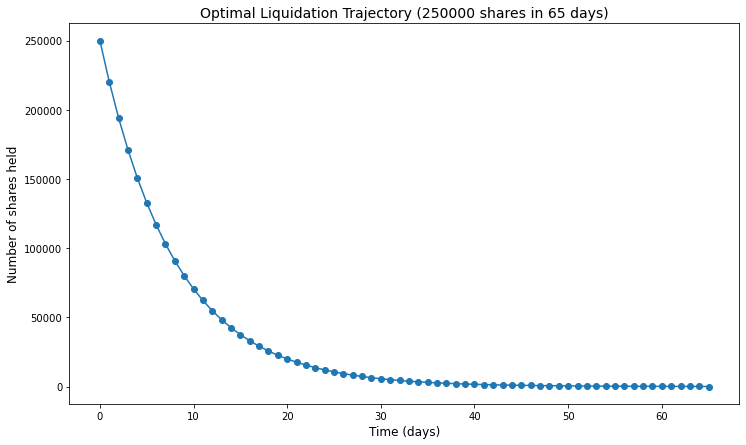

In [6]:
X = 250000
T = len(data)

model = AlmgrenChriss1D(params)
trajectory = model.trajectory(X,T)

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()

### Optimal Trajectory Sensitivity

We explore how the optimal trajectory varies with different parameters.

#### Risk-Aversion

We explore different values of $\lambda$.

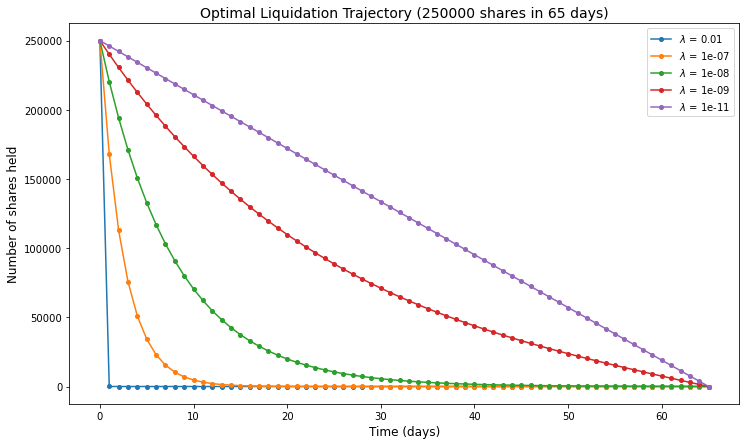

In [7]:
lambdas = [1e-2, 1e-7, 1e-8, 1e-9, 1e-11]

plt.figure(figsize=(12,7))
for _lambda in lambdas:
    new_params = params.copy()
    new_params['lambda'] = _lambda
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\lambda$ = {_lambda}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

When $\lambda$ is closer to 0, the optimal trajectory approches an eqaul-sized packet trajectory in which the agent sells the same amount of shares each day. In this case, the agent does not care about the risk, the transaction costs are reduced since trade volumes are much smaller, and the variance of the total trading cost increases.

When $\lambda$ is further away from 0, the optimal trajectory involves selling most of the shares during the first days since the agent does not want to take on the risk of holding them for too long. In this case, the transaction cost would be huge due to a big market impact, but the strategy leads to a low the variance of the total trading cost.

#### Permanent Market Impact

We explore different values of $\gamma$.

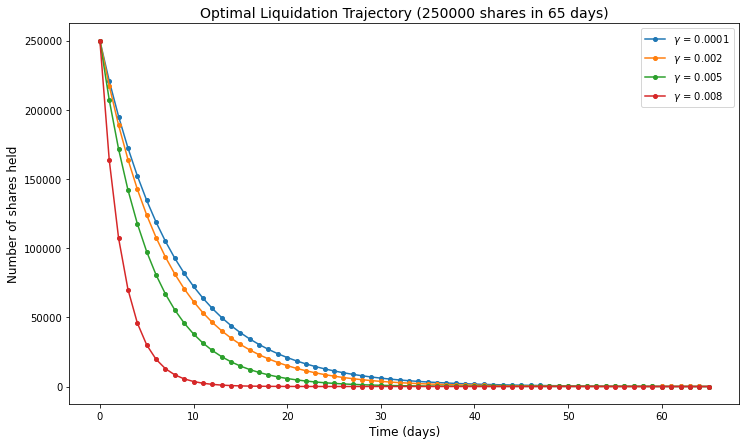

In [8]:
gammas = [0.0001,0.002,0.005,0.008]

plt.figure(figsize=(12,7))
for gamma in gammas:
    new_params = params.copy()
    new_params['gamma'] = gamma
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\gamma$ = {gamma}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

When $\gamma$ is larger, the optimal trading strategy involves selling more shares earlier leading to higher transaction costs but lower variance of the total trading cost. Since larger $\gamma$ means more permanent market impact, it is optimal to sell the shares quickly, instead of holding on to the shares with impacted prices.

#### Temporary Market Impact
We explore different values of $\eta$.

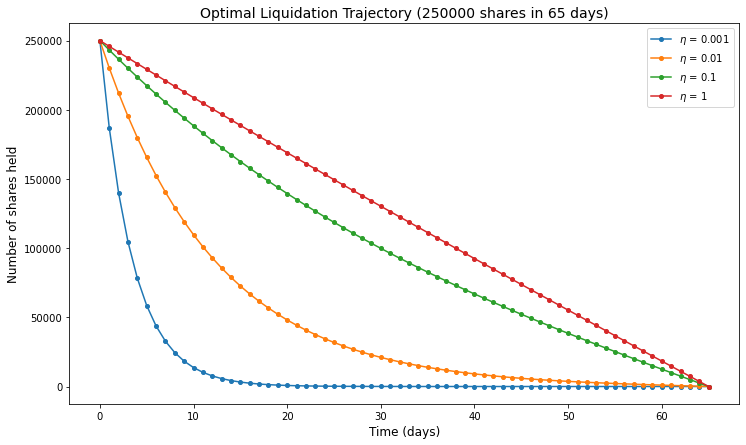

In [9]:
etas = [0.001,0.01,0.1,1]

plt.figure(figsize=(12,7))
for eta in etas:
    new_params = params.copy()
    new_params['eta'] = eta
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\eta$ = {eta}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

When $\eta$ is larger, the optimal trading trajectory approches the equal-packet trajectory. Larger $\eta$ means that there is more temporary market impact. This means that if you sell a large amount on a given day, the price of the asset would fall on that day (but recover the next day since it's a temporary impact). This means that is is optimal to sell only a small amount each day and wait for the price to recover if temporary market impact is high.

Furthermore, the optimal trading trajectory does not vary with $\epsilon$. However, the expected value of the total trading cost increases linearly with $\epsilon$.

## Multiple Assets

We now numerically illustrate the Almgren-Chriss model with financial data for two (correlated) assets. In particular, we use the daily historical prices of Alphabet Inc. (NASDAQ:GOOG) and Meta Platforms, Inc. (NASDAQ:FB) during the past three months.

### Data
We use the Yahoo Finance API to obtain historical price data.

In [10]:
goog = yf.Ticker('GOOG')
data1 = goog.history(period='3mo')
display(data1)
print(np.mean(data1['Volume'])/4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-13,2767.149902,2773.479980,2760.100098,2768.120117,628600,0,0
2021-08-16,2760.000000,2779.810059,2723.314941,2778.320068,902000,0,0
2021-08-17,2763.820068,2774.370117,2735.750000,2746.010010,1063600,0,0
2021-08-18,2742.310059,2765.879883,2728.419922,2731.399902,746700,0,0
2021-08-19,2709.350098,2749.040039,2707.120117,2738.270020,914800,0,0
...,...,...,...,...,...,...,...
2021-11-08,3000.000000,3020.689941,2982.399902,2987.030029,919400,0,0
2021-11-09,2994.919922,3007.570068,2950.139893,2984.969971,843800,0,0
2021-11-10,2960.195068,2974.000000,2906.500000,2932.520020,1135400,0,0


276636.53846153844


In [11]:
fb = yf.Ticker('FB')
data2 = fb.history(period='3mo')
display(data2)
print(np.mean(data2['Volume'])/4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-13,362.970001,364.660004,361.480011,363.179993,7192500,0,0
2021-08-16,362.519989,366.950012,357.380005,366.559998,11222100,0,0
2021-08-17,362.980011,364.670013,355.070007,358.450012,12328700,0,0
2021-08-18,356.250000,359.859985,355.149994,355.450012,10042400,0,0
2021-08-19,351.350006,357.570007,351.000000,355.119995,12004500,0,0
...,...,...,...,...,...,...,...
2021-11-08,344.420013,344.790009,338.339996,338.619995,18342500,0,0
2021-11-09,340.000000,341.309998,334.470001,335.369995,17556700,0,0
2021-11-10,332.489990,333.190002,325.510010,327.640015,21872600,0,0


4955159.615384615


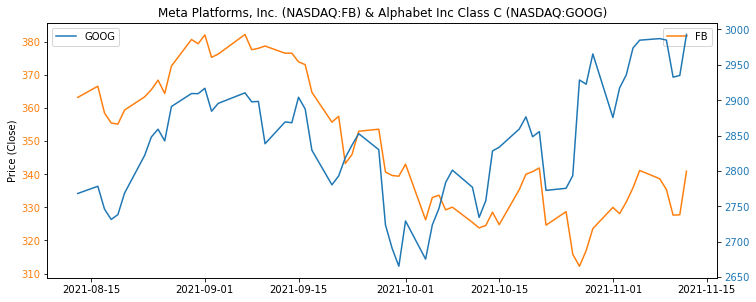

In [12]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(data2.index, data2["Close"], color='tab:orange', label='FB')
top_plt.set_ylabel('Price (Close)')
top_plt.set_xticks([])
top_plt.legend()
top_plt.tick_params(axis='y', labelcolor='tab:orange')
top_plt2 = top_plt.twinx()
top_plt2.plot(data1.index, data1["Close"], label='GOOG')
top_plt2.tick_params(axis='y',labelcolor='tab:blue')
top_plt2.legend()
plt.title('Meta Platforms, Inc. (NASDAQ:FB) & Alphabet Inc Class C (NASDAQ:GOOG)')
plt.gcf().set_size_inches(12,8)

### Parameter Calibration

We explain the meaning of the new parameters and compute the parameters with the data.

- $C$ is the variance-covariance matrix (the multi-dimensional equivalent of $\sigma$). It a measure of the volatility of the assets and how they are correlated. For the sake of this example, we compute $C$ using the data of future prices for a trading strategy in the past. This would not be possible in real implementations where $C$ would have to be estimated.
- $\Gamma$ is a 2x2 matrix that is the permanent market parameter (the multi-dimensional equivalent of $\gamma$). Assming a linear market impact, the $ij$ element of $\Gamma$ represents the price depression of asset $i$ cause by selling asset $j$ at unit rate.
- $H$ is a 2x2 matrix that is the temporary market impact parameter (the multi-dimensional equivalent of $\eta$). Similarly, the $ij$ element of $H$ represents the price depression of asset $i$ cause by selling asset $j$ at unit rate. 

$H$ and $\Gamma$ are not assumed to be symmetric. However, $H$ is required to be positive definite.

We calibrate $H$ and $\Gamma$ as diagonal matrices (see general model extension for non-diagonal case):

$$H = \begin{pmatrix}
\frac{\text{Spread}_1}{0.01 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.01 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

$$\Gamma = \begin{pmatrix}
\frac{\text{Spread}_1}{0.1 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.1 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$


In [13]:
average_daily_volume1 = np.mean(data1['Volume'])
average_daily_volume2 = np.mean(data2['Volume'])
average_daily_spread1 = np.mean(data1['High'] - data1['Low'])
average_daily_spread2 = np.mean(data2['High'] - data2['Low'])

C = np.cov(data1['Close'], data2['Close'])

epsilon = (average_daily_spread1 + average_daily_spread2)/2


H = np.array([[average_daily_spread1/(0.01*average_daily_volume1), 0],
              [0, average_daily_spread2/(0.01*average_daily_volume2)]])

Gamma = np.array([[average_daily_spread1/(0.1*average_daily_volume1), 0],
                  [0, average_daily_spread2/(0.1*average_daily_volume2)]])

tau = 1

params = {
    'lambda': 1e-08,
    'C': C,
    'epsilon': epsilon,
    'H': H,
    'Gamma': Gamma,
    'tau': tau
}

print('Parameters:')
for k,v in params.items():
    print(f'{k} =\n {v}')

Parameters:
lambda =
 1e-08
C =
 [[6749.02820981  224.52711739]
 [ 224.52711739  415.87895921]]
epsilon =
 27.892161677433894
H =
 [[4.36436461e-03 0.00000000e+00]
 [0.00000000e+00 3.77919949e-05]]
Gamma =
 [[4.36436461e-04 0.00000000e+00]
 [0.00000000e+00 3.77919949e-06]]
tau =
 1


### Implementation

For $m$ assets, given $\lambda$, $C$, $\epsilon$, $H$, $\Gamma$, and $\tau$, we can compute the optimal trading trajectory $(x_0,..,x_N).T$ for initial position $X$ and time-to-liquidate $T$ with the following equations:

$$x_0 = X \quad \text{and} \quad x_N = 0$$

$$\Gamma^S = \frac{1}{2} (\Gamma^\top + \Gamma),\quad \Gamma^A = \frac{1}{2} (\Gamma - \Gamma^\top), \quad \text{and} \quad H^S = \frac{1}{2} (H^\top + H)$$

$$\tilde{H} = H^S - \frac{\tau}{2}\Gamma^S$$

$$\tilde{H}^{1/2}  \tilde{H}^{1/2} = \tilde{H}$$

$$A = (\tilde{H}^{1/2})^{-1} C (\tilde{H}^{1/2})^{-1} \quad \text{and} \quad B = (\tilde{H}^{1/2})^{-1} \Gamma^A (\tilde{H}^{1/2})^{-1}$$

For all $k \in \{0,...N-1\}$,

$$y_k = \tilde{H}^{1/2} x_k \iff x_k = (\tilde{H}^{1/2})^{-1} y_k$$

$$\frac{y_{k-1} - 2 y_k + y_{k+1}}{\tau^2} = \lambda A y_k + B \frac{y_{k-1} - y_{k+1}}{2\tau}$$

$$y_N = \mathbf{0}$$

If $H$ and $\Gamma$ are diagonal, let $\tilde{\kappa}_1^2,...\tilde{\kappa}_m^2$ be the eigenvalues of $\lambda A$ and $U$ be an orthogonal matrix such that $\lambda A = U D U ^\top$ where $D$ is a diagonal matrix.

Then for all $j \in \{0,...,m\}$  and $k \in \{0,...N\}$,

$$\frac{2}{\tau^2} (\cosh(\kappa_j \tau) - 1) = \tilde{\kappa}^2_j \iff \kappa_j = \frac{1}{\tau}\text{arccosh}\left(\frac{\tilde{\kappa_j}^2 \tau^2}{2} + 1\right)$$

$$z_{j0} = U^\top \tilde{H}^{1/2} X$$

$$z_{jk} = \frac{\sinh(\kappa_j(T-t_k))}{\sinh(\kappa_j T)} z_{j0}$$

$$x_k = (\tilde{H}^{1/2})^{-1} U z_k$$

In [14]:
def decompose(A):
    # Return symmetric and anit-symmetric parts of a given matrix (A = A_s + A_a)
    A_s = 0.5 * (A + A.T)
    A_a = 0.5 * (A - A.T)
    return (A_s, A_a)

def is_diagonal(A):
    # Return True if matrix is diagonal
    i, j = np.nonzero(A)
    return np.all(i == j)

class AlmgrenChriss:
    def __init__(self, params):
        
        # Initialize Parameters
        self._lambda = params['lambda']
        self._C = params['C']
        self._epsilon = params['epsilon']
        self._H = params['H']
        self._Gamma = params['Gamma']
        self._tau = params['tau']
        
        # Dimensions
        self._dims = self._C.shape[0]
        
        # Decompose martrices
        self._H_s, self._H_a = decompose(self._H)
        self._Gamma_s, self._Gamma_a = decompose(self._Gamma)
        
        self._H_tilda = self._H_s - 0.5*self._Gamma_s*self._tau
        
        # Ensure positive-definite (for invertibility) 
        assert np.all(np.linalg.eigvals(self._H_tilda) > 0)
        
        self._A = np.linalg.inv(sqrtm(self._H_tilda))@self._C@np.linalg.inv(sqrtm(self._H_tilda))
        self._B = np.linalg.inv(sqrtm(self._H_tilda))@self._Gamma_a@np.linalg.inv(sqrtm(self._H_tilda))
        
        if is_diagonal(self._H_tilda):
            self._kappa_tilda_squareds, self._U = np.linalg.eig(self._lambda*self._A)            
            self._kappas = np.arccosh(0.5*(self._kappa_tilda_squareds*self._tau**2) + 1)/self._tau

    def trajectory(self, X, T, general=False):
        # Optimal Liquidation Trajectory
        traj = []
        if not general:
            # Diagonal Model
            if not is_diagonal(self._H_tilda): raise ValueError
            z0 = self._U.T@sqrtm(self._H_tilda)@X
            for t in range(T+1):
                z = np.sinh(self._kappas*(T - t))/np.sinh(self._kappas*T)*z0
                x = np.floor(np.linalg.inv(sqrtm(self._H_tilda))@self._U@z)
                traj.append(x)
        else:
            # General Model (only supported for 2 dimensions - did not have time to generalize)
            if self._dims != 2: raise ValueError
            # Transformation
            y0 = sqrtm(self._H_tilda)@X
            # Build Linear System
            rhs = np.zeros(2*(T+1))
            # Initial Conditions
            rhs[0] = y0[0]
            rhs[1] = y0[1]
            init1 = np.zeros(2*(T+1))
            init1[0] = 1
            init2 = np.zeros(2*(T+1))
            init2[1] = 1
            system = [init1,init2]
            # System
            for k in range (0,T-1):
                a = (1/self._tau**2)
                b = 1/(2*self._tau)
                c = -2/(self._tau**2)
                l = self._lambda
                A = self._A
                B = self._B
                equation1_coeff = [
                    a - b*B[0,0],
                    -b*B[0,1],
                    c - l*A[0,0],
                    -l*A[0,1],
                    a + b*B[0,0],
                    b*B[0,1] 
                ]
                equation2_coeff = [
                    -b*B[1,0],
                    a - b*B[1,1],
                    -l*A[1,0],
                    c - l*A[1,1],
                    b*B[1,0],
                    a + b*B[1,1] 
                ]
                system.append(np.array([0]*2*k + equation1_coeff + [0]*2*(T-k-2)))
                system.append(np.array([0]*2*k + equation2_coeff + [0]*2*(T-k-2)))
            # Final Conditions
            final1 = np.zeros(2*(T+1))
            final1[-2] = 1 
            system.append(final1) # y_{1,N} = 0
            final2 = np.zeros(2*(T+1))
            final2[-1] = 1
            system.append(final2) # y_{2,N} = 0
            # Solve Linear System
            sol = np.linalg.solve(np.array(system), rhs)
            y = sol.reshape(T+1,2)
            # Undo Transformation
            for yk in y:
                traj.append(np.linalg.inv(sqrtm(self._H_tilda))@yk)
        return np.array(traj).T

    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X,T))

### Example

For example, using the parameters previously calibrated, we plot the optimal trading trajectory for selling 250 thousand shares of FB and 250 thousand shares of GOOG during the full period of all 3 months.

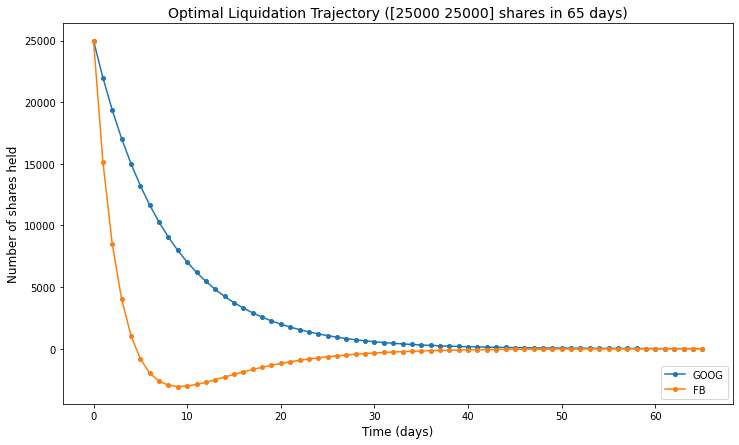

In [15]:
X = np.array([25000,25000]).T
T = len(data1)

model = AlmgrenChriss(params)
trajectory = model.trajectory(X,T, general=False)
assert np.any(trajectory == model.trajectory(X,T, general=True))

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory[0],'o-',ms=4,label='GOOG')
plt.plot(range(T+1),trajectory[1],'o-',ms=4,label='FB')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend(loc=4)
plt.show()

### Optimal Trajectory Sensitivity

We explore how the optimal trajectory varies with different parameters.

#### Risk-Aversion

We explore different values of $\lambda$.

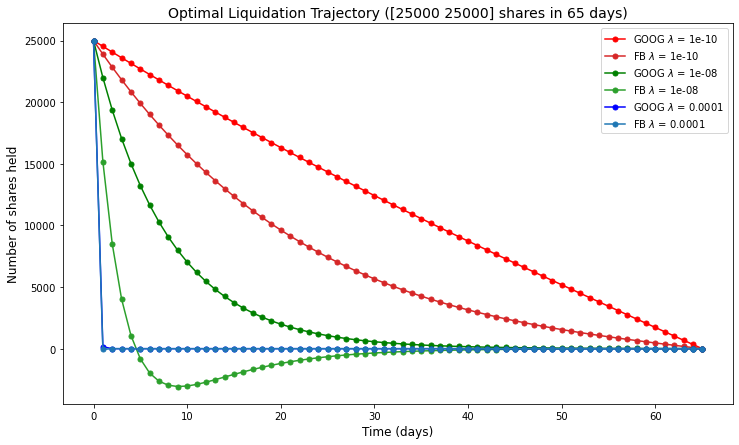

In [16]:
lambdas = [(1e-10, 'red'),(1e-8, 'green'),(1e-4,'blue')]

plt.figure(figsize=(12,7))
for _lambda, color in lambdas:
    new_params = params.copy()
    new_params['lambda'] = _lambda
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG $\lambda$ = {_lambda}', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB $\lambda$ = {_lambda}', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

Just as in the one-dimensional case, when $\lambda$ is closer to 0, the optimal trajectory approches an eqaul-sized packet trajectory in which the agent sells the similar amount of shares each day. When $\lambda$ is further away from 0, the optimal trajectory involves selling most of the shares during the first days.

What is interesting to notice is that for values of $\lambda$ with order of magnitude around $10^{-8}$, the optimal strategy involves selling a shares early and even taking a short position in one of them. This is because the price of the assets are correlated. As mentioned in the paper, it is possible for some components of the velocity to be non-monotonic in time. In this case, the model is not exactly correct due to the chnaging sign of the cost associated with the bid-ask spread but this effect is probably small.

#### Correlation
We explore the optimal trajectory for different correlations between the assets.

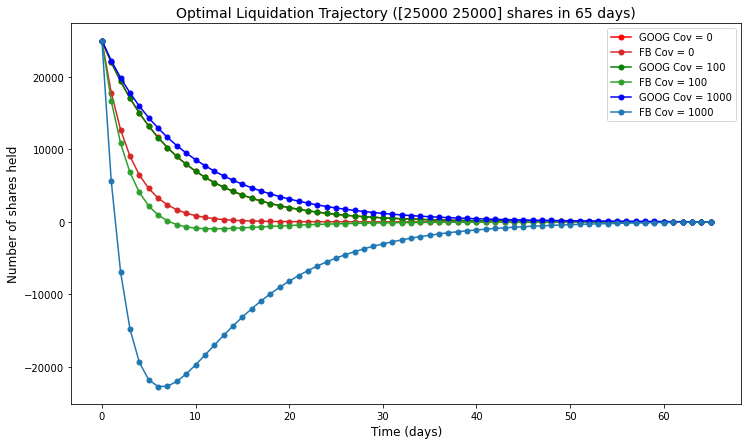

In [17]:
covs = [(0, 'red'),(100, 'green'),(1000,'blue')]

plt.figure(figsize=(12,7))
for cov, color in covs:
    new_params = params.copy()
    C = np.cov(data1['Close'], data2['Close'])
    C[1][0] = cov
    C[0][1] = cov
    new_params['C'] = C.copy()
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T, general=True)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG Cov = {cov}', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB Cov = {cov}', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

Indeed, we see that when correlation is stronger, one assset is first shorted and then the position is slowly reduced.

#### Permanant Market Impact

We explore different values of $\Gamma$.

$$\Gamma_0 = \begin{pmatrix}
\frac{\text{Spread}_1}{0.1 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.1 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

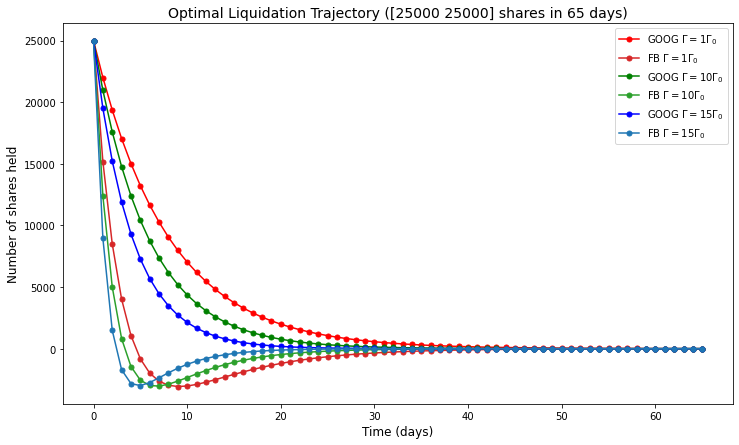

In [18]:
gammas = [(1, 'red'),(10, 'green'),(15,'blue')]

plt.figure(figsize=(12,7))
for gamma, color in gammas:
    new_params = params.copy()
    new_params['Gamma'] = gamma*params['Gamma']
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T, general=True)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG $\Gamma = {gamma}\Gamma_0$', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB $\Gamma = {gamma}\Gamma_0$', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

As in the one-dimensional case, higher permanant market impact means selling the assests quicky. 

We now fix the permanent market impact of one asset and vary the other.

$$\Gamma_0(x) = \begin{pmatrix}
x & 0 \\
0 & 1 \\
\end{pmatrix} \begin{pmatrix}
\frac{\text{Spread}_1}{0.1 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.1 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}
$$

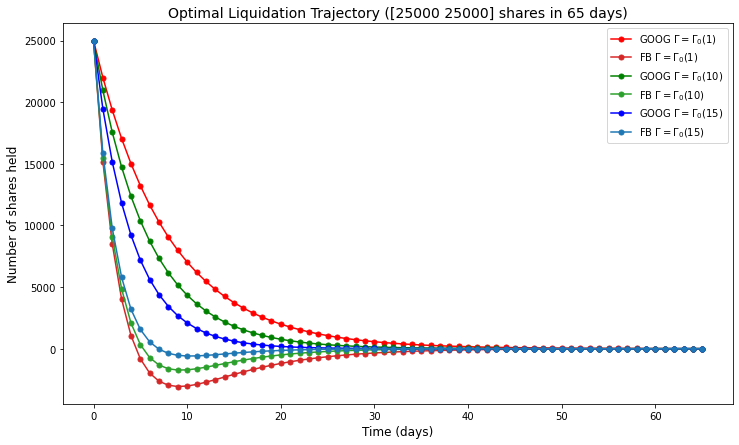

In [19]:
gammas = [(1, 'red'),(10, 'green'),(15,'blue')]

plt.figure(figsize=(12,7))
for gamma, color in gammas:
    new_params = params.copy()
    new_params['Gamma'] = np.diag([gamma,1])@params['Gamma']
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T, general=True)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG $\Gamma = \Gamma_0({gamma})$', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB $\Gamma = \Gamma_0({gamma})$', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

Higher permanent market impact for one asset leads to less short selling of the other asset.

#### Temporary Market Impact

We explore different values of $H$.

$$H_0 = \begin{pmatrix}
\frac{\text{Spread}_1}{0.01 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.01 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

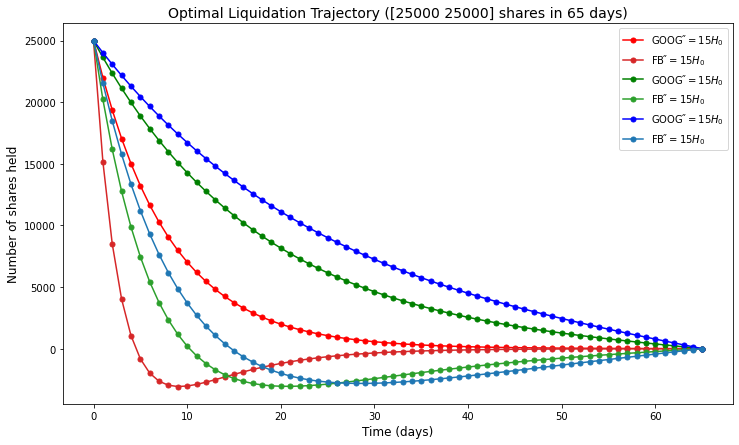

In [20]:
Hs = [(1, 'red'),(5, 'green'),(10,'blue')]

plt.figure(figsize=(12,7))
for H, color in Hs:
    new_params = params.copy()
    new_params['H'] = H*params['H']
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T, general=True)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG $\H = {gamma}H_0$', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB $\H = {gamma}H_0$', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

As in the one-dimensional case, higher temporary market impact leads to equal-sized packet strategy.

We now fix the temporary market impact of one asset and vary the other.

$$H_0(x) = \begin{pmatrix}
x & 0 \\
0 & 1 \\
\end{pmatrix} \begin{pmatrix}
\frac{\text{Spread}_1}{0.01 \times \text{Avg. Daily Volume}_1} & 0\\
0 & \frac{\text{Spread}_2}{0.01 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

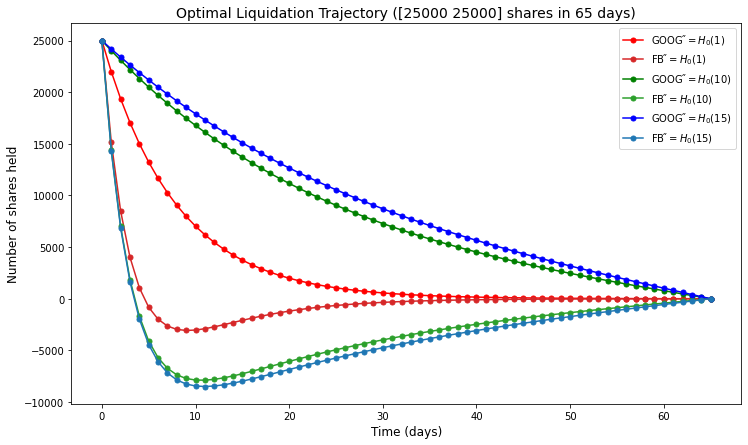

In [21]:
Hs = [(1, 'red'),(10, 'green'),(15,'blue')]

plt.figure(figsize=(12,7))
for H, color in Hs:
    new_params = params.copy()
    new_params['H'] = np.diag([H,1])@params['H']
    model = AlmgrenChriss(new_params)
    trajectory = model.trajectory(X,T, general=True)
    plt.plot(range(T + 1),trajectory[0],'o-',ms=5, label=f'GOOG $\H = H_0({H})$', color=color)
    plt.plot(range(T + 1),trajectory[1],'o-',ms=5, label=f'FB $\H = H_0({H})$', color='tab:'+color)
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

Higher temporary market impact for one asset leads to shorting more of the other asset.

## Conclusion & Extensions

The Almgren-Chirss model allows the selection of an optimal liquidation strategy based on the classic mean-variance optimization of the total trading cost. If the trader is risk averse, though, the magnitude of his trades declines over time. The model may be extended by taking the limit $\tau \to 0$, however, the model is implicitly a "coarse-grained" description of real dynamics. Further extensions may include non-linear cost functions. The framework developed by Almgren and Chriss is not limited to linear market impact functions. Non-linear cost functions would require solving a nonquadratic optimization problem and the difficulty of this problem depends on the specific functional form chosen. One can also vary parameters such as volatility over time, this entails solving a linear system (as in the general model). This is useful is if, for example, the price is expected to jump on a known future date due to an earnings announcement.

### Application: General Model

*A mathematical argument for financial crime.*

We explore a particular case of trading shares of the same company on different exchanges. In particular, we explore the optimal strategy for closing a position of Carnival Corporation & plc (CCL) over the past 15 days.
CCL is a British-American cruise operator which is currently the world's largest travel leisure company. Shares of CCL are traded on both the NYSE and the LSE.

Suppose you work for an international hedge fund. The firm owns 100000 shares of NYSE:CCL and 15000 shares of LSE:CCL. The fundamental analysts at your firm believe that CCL is no longer a good investment and you have to close the position. You are given 15 days to do so.

We suppose that we can take on quite a lot of risk such that $\lambda = 10^{-8}$.

In [22]:
nyse_ccl = yf.Ticker('CCL')
data_nyse_ccl = nyse_ccl.history(period='15d')
display(data_nyse_ccl)
print(np.mean(data_nyse_ccl['Volume'])/4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-25,21.790001,22.170000,21.719999,22.049999,26140400,0,0
2021-10-26,22.170000,22.469999,21.660000,21.820000,25617900,0,0
2021-10-27,21.900000,22.000000,21.610001,21.639999,20827900,0,0
2021-10-28,21.639999,22.080000,21.309999,21.969999,23048700,0,0
2021-10-29,21.879999,22.469999,21.770000,22.160000,26672500,0,0
2021-11-01,22.299999,23.100000,22.010000,23.070000,27315500,0,0
2021-11-02,22.980000,23.070000,22.549999,22.910000,21579400,0,0
2021-11-03,22.709999,23.330000,22.570000,23.170000,23001300,0,0
2021-11-04,23.330000,23.490000,22.730000,22.879999,20186900,0,0


6932458.333333333


In [23]:
lse_ccl = yf.Ticker('CCL.L')
data_lse_ccl = lse_ccl.history(period='15d')
display(data_lse_ccl)
print(np.mean(data_lse_ccl['Volume'])/4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-25,1452.000000,1467.400024,1438.800049,1457.800049,995075,0,0
2021-10-26,1461.000000,1501.000000,1449.239990,1483.800049,1054594,0,0
2021-10-27,1480.400024,1484.949951,1453.800049,1463.800049,1239473,0,0
2021-10-28,1442.000000,1464.199951,1432.599976,1451.199951,819669,0,0
2021-10-29,1456.000000,1498.599976,1450.199951,1470.000000,923586,0,0
2021-11-01,1490.000000,1533.599976,1451.280029,1528.800049,943041,0,0
2021-11-02,1533.599976,1552.599976,1515.400024,1524.000000,969083,0,0
2021-11-03,1525.000000,1556.000000,1503.199951,1549.000000,1417830,0,0
2021-11-04,1567.599976,1581.000000,1542.199951,1550.000000,894688,0,0


306475.51666666666


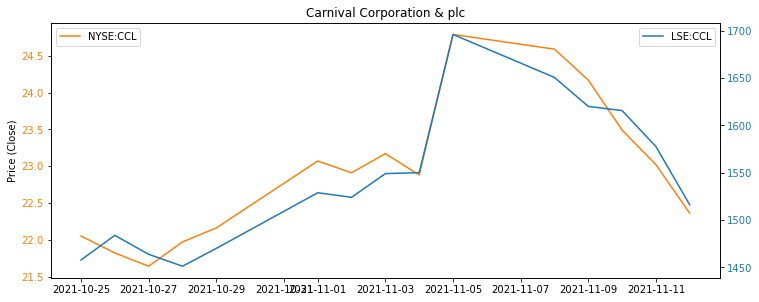

In [24]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(data_nyse_ccl.index, data_nyse_ccl["Close"], color='tab:orange', label='NYSE:CCL')
top_plt.set_ylabel('Price (Close)')
top_plt.set_xticks([])
top_plt.legend(loc=2)
top_plt.tick_params(axis='y', labelcolor='tab:orange')
top_plt2 = top_plt.twinx()
top_plt2.plot(data_lse_ccl.index, data_lse_ccl["Close"], label='LSE:CCL')
top_plt2.tick_params(axis='y',labelcolor='tab:blue')
top_plt2.legend(loc=1)
plt.title('Carnival Corporation & plc')
plt.gcf().set_size_inches(12,8)

As we can see from the graph, the share prices of the company on both exchanges are strongly correlated as expected. Furthermore, in such a case, we would expect high cross-market impact of trades i.e trades performed on one exchange would strongly affect the price on the other exchange. Therefore, using the diagonal model to compute the optimal liquidation strategy would not be appropriate. Hence, we calibrate $H$ and $\Gamma$ as follows (the 7 in permanent cross-market impact is somewhat arbitrary and was added for the sake of this example):

$$H = \begin{pmatrix}
\frac{\text{Spread}_1}{0.01 \times \text{Avg. Daily Volume}_1} & \frac{\text{Spread}_1}{0.01 \times \text{Avg. Daily Volume}_2}\\
\frac{\text{Spread}_2}{0.01 \times \text{Avg. Daily Volume}_1} & \frac{\text{Spread}_2}{0.01 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

$$\Gamma = \begin{pmatrix}
\frac{\text{Spread}_1}{0.1 \times \text{Avg. Daily Volume}_1} & \frac{\text{Spread}_1}{0.1 \times \text{Avg. Daily Volume}_2}\\
\frac{7 \times \text{Spread}_2}{0.1 \times \text{Avg. Daily Volume}_1} & \frac{\text{Spread}_2}{0.1 \times \text{Avg. Daily Volume}_2}
\end{pmatrix}$$

Parameters:
lambda =
 1e-08
C =
 [[9.75950128e-01 7.17447374e+01]
 [7.17447374e+01 5.68194375e+03]]
epsilon =
 28.42139186859131
H =
 [[2.75756030e-06 6.23758533e-05]
 [6.23758533e-05 4.57443693e-03]]
Gamma =
 [[2.75756030e-07 6.23758533e-06]
 [1.41561189e-04 4.57443693e-04]]
tau =
 1


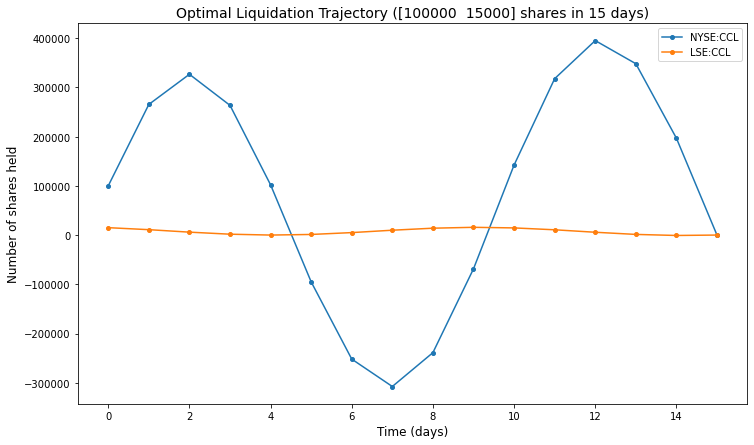

In [25]:
average_daily_volume_nyse = np.mean(data_nyse_ccl['Volume'])
average_daily_volume_lse = np.mean(data_lse_ccl['Volume'])
average_daily_spread_nyse = np.mean(data_nyse_ccl['High'] - data_nyse_ccl['Low'])
average_daily_spread_lse = np.mean(data_lse_ccl['High'] - data_lse_ccl['Low'])

C = np.cov(data_nyse_ccl['Close'], data_lse_ccl['Close'])

epsilon = (average_daily_spread_nyse + average_daily_spread_lse)/2

H = np.array([[average_daily_spread_nyse/(0.01*average_daily_volume_nyse), average_daily_spread_nyse/(0.01*average_daily_volume_lse)],
              [average_daily_spread_nyse/(0.01*average_daily_volume_lse), average_daily_spread_lse/(0.01*average_daily_volume_lse)]])

Gamma = np.array([[average_daily_spread_nyse/(0.1*average_daily_volume_nyse), average_daily_spread_nyse/(0.1*average_daily_volume_lse)],
                  [7*average_daily_spread_lse/(0.1*average_daily_volume_nyse), average_daily_spread_lse/(0.1*average_daily_volume_lse)]])

tau = 1

params = {
    'lambda': 1e-8,
    'C': C,
    'epsilon': epsilon,
    'H': H,
    'Gamma': Gamma,
    'tau': tau
}

initial_nyse = 100000
initial_lse = 15000

print('Parameters:')
for k,v in params.items():
    print(f'{k} =\n {v}')
    
X = np.array([initial_nyse, initial_lse]).T
T = len(data_lse_ccl)

model = AlmgrenChriss(params)
trajectory = model.trajectory(X,T,general=True)

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory[0],'o-',ms=4,label='NYSE:CCL')
plt.plot(range(T+1),trajectory[1],'o-',ms=4,label='LSE:CCL')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend(loc=1)
plt.show()

The optimal strategy is then to buy on the NYSE while selling on the LSE and sell on the NYSE while buying on the LSE. We start by selling on the LSE and this drives the price down on both exchanges. Then we buy with a lower price on the NSYE and this raises the price on the both exchanges. We then sell on the LSE for a higher price and so on. The strategy is optimal since the parameters imply that executing an order on the LSE has more of an impact on the NYSE than executing an order on the NYSE has on the LSE. In reality, this is not common, but with high-frequency trading algorithms today, oppurtunites like this are not difficult to identify. This is in a sense an arbitrage strategy that exploits market impact inefficiencies.

However, it's indeed too good to be true. This is a illegal cross-market manipulation scheme: traders placing orders to trade a financial product with the intent of impacting the same or similar product on a market in a different venue. With the advent of high-frequency trading, cross-market manipulation is considered one of the most volatile and dangerous forms of white-collar crime and a priority for the Department of Justice and regulators alike. In fact, European regulators recently announced plans to step up their focus on cross-market manipulation surveillance. The problem of market manipulation in optimal portfolio trading is explored in Gur Huberman, Werner Stanzl's 2004 paper: "Price Manipulation and Quasi-Arbitrage". 